# Empty Galaxy Catalog

## Load data

In [1]:
import os,sys
os.environ['CHIMERA_ENABLE_GPU'] = "False"
sys.path.append('/home/mt//softwares/chimera_dev/CHIMERA_JAX/')
from CHIMERA import data as data

file_ev   = "./data/PE_O5Like_snr20.h5"
theta_pe_det = data.load_gw_pe_samples(file_ev, 
                                 parameters=['m1det', 'm2det', 'dL'], 
                                 return_struct=True)
theta_pe_det = theta_pe_det.update(pe_prior=theta_pe_det.dL**2)
nev = len(theta_pe_det.dL)
print(f'Loaded {nev} GW events')

2025-08-07 14:46:01,916 - CHIMERA - INFO - Loading `CHIMERA`. GPU acceleration: False


Loaded 300 GW events


## Instantiate population model

In [2]:
from CHIMERA.cosmo import flrw
from CHIMERA.mass import plp
from CHIMERA.rate import madau_dickinson
from CHIMERA import compute_z_grids, population

# define population models with some fiducials
cosmo = flrw(H0 = 70., 
             Om0=0.25, 
             z_max = 5.)
mass = plp()
rate = madau_dickinson(gamma = 2.7,
                       kappa =  3.,
                       zp = 2.)


population = population(cosmo, mass, rate, scale_free=True)

# compute the z_grid where we will integrate the likelihood
z_grids = compute_z_grids(cosmo, 
                          theta_pe_det,
                          cosmo_prior = {'H0':[20,200]}, 
                          z_int_res = 500,)

## Instantiate the Selection Function module

In [3]:
from CHIMERA import selection_function

file_inj = "./data/injections_20M_sources_PLP_v9s2_H1-L1-Virgo-KAGRA-LIGOI_IMRPhenomHM_snr_th-20_dutyfac-1_fmin-10_noiseless.h5"
theta_inj_det = data.load_injection_data(file_inj, snr_cut=20, return_struct=True)

sel_fcn = selection_function(theta_inj_det,
                             N_inj=20*1e6,
                             N_eff=5*nev)

## Instantiate the Hyperlike

In [4]:
from CHIMERA import hyperlikelihood

like_jax = hyperlikelihood(  # data
  theta_pe_det,
  # integration grids
  z_grids,
  # population
  population=population,
  # selection function
  selection_function=sel_fcn,
  # KDE settings
  kernel='epan', # 'gauss'
  bw_method=None,
  cut_grid=2,
  binning=True,
  num_bins=200,
  pe_neff = 2.,
)

2025-07-30 10:39:27,281 - CHIMERA - INFO - Created hyperlikelihood model. Using 300 GW events.


## 1d on H0

50it [00:31,  1.58it/s]


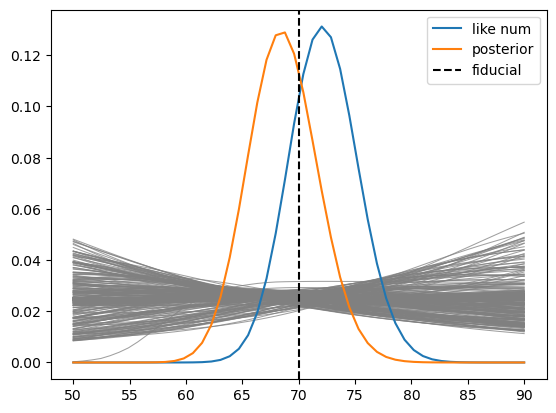

In [5]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt

H0 = np.linspace(50, 90, 50)
log_like_nums = np.zeros((H0.shape[0], like_jax.nevents))
res_H0 = np.zeros_like(H0)
log_bias = np.zeros_like(H0)

for i, h0 in tqdm.tqdm(enumerate(H0)):
  res = like_jax.compute_all(H0=h0)
  log_like_nums[i] = res[0] 
  log_bias[i] = res[2]
  res_H0[i] = res[3]

# exponentiate and normalize

likenum_H0 = np.sum(log_like_nums, axis = -1)
likenum_H0 -=np.nanmax(likenum_H0)
ln_jax = np.exp(likenum_H0)/np.trapezoid(np.exp(likenum_H0), x=H0)

log_post_ev = log_like_nums - log_bias[:,None]
log_post_ev -= np.nanmax(log_post_ev)
post_ev = np.exp(log_post_ev) 
norms = np.trapezoid(post_ev, x=H0, axis=0)

post_jax = res_H0.copy()
post_jax -= np.nanmax(post_jax)
post_jax = np.exp(post_jax)
post_jax /= np.trapezoid(post_jax, H0)

[plt.plot(H0, post_ev[:,e]/norms[e], c='gray', lw=0.75, alpha=0.75) for e in range(like_jax.nevents)]
plt.plot(H0, ln_jax, label='like num')
plt.plot(H0, post_jax, label='posterior')
plt.axvline(70, ls='--', c='k', label= 'fiducial')
plt.legend()
plt.show()